<a href="https://colab.research.google.com/github/Text2TCS/Transrelation/blob/master/CogALex_XLM_RoBERTa_Updated_Task_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 1.5MB 7.9MB/s 
     |████████████████████████████████| 890kB 28.9MB/s 
     |████████████████████████████████| 2.9MB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e36db39f3fe6fe180e08f12a98a4819adee0292cc3b798c15ec46a46b99ff5d3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.1MB 9.2MB/s 


In [3]:
import torch                                              #for training the model
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import pandas as pd                                       #for handling the data
from transformers import XLMRobertaTokenizer              #for loading the pretrained model and tokenizer
from transformers import XLMRobertaForSequenceClassification
from transformers import AdamW                            
from transformers import get_linear_schedule_with_warmup
from sklearn import preprocessing                         #for label encoding
from sklearn.metrics import classification_report         #for showing performance on validation/test sets
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid         #for gridsearch
import sentencepiece
import matplotlib.pyplot as plt
import time
import datetime
import random
import numpy as np
% matplotlib inline
import seaborn as sns

# Load Data

Load data from text files 

In [4]:
# sk learn label encoder for changing the labels to integers
labels=["ANT", "HYP", "RANDOM", "SYN"]
le = preprocessing.LabelEncoder()
le.fit(labels)

#chinese 
data_train_zh = pd.read_csv('data/train/train_chinese_data.txt', sep="\t", header=None)
data_train_zh.columns = ["Word1", "Word2", "Label"]

data_valid_zh = pd.read_csv('data/valid/validgold_chinese_data.txt', sep="\t", header=None)
data_valid_zh.columns = ["Word1", "Word2", "Label"]

data_train_zh["Label"]=le.transform(data_train_zh["Label"])
data_valid_zh["Label"]=le.transform(data_valid_zh["Label"])

#english 
data_train_en = pd.read_csv('data/train/train_english_data.txt', sep="\t", header=None)
data_train_en.columns = ["Word1", "Word2", "Label"]

data_valid_en = pd.read_csv('data/valid/validgold_english_data.txt', sep="\t", header=None)
data_valid_en.columns = ["Word1", "Word2", "Label"]

data_train_en["Label"]=le.transform(data_train_en["Label"])
data_valid_en["Label"]=le.transform(data_valid_en["Label"])

#german 
data_train_de = pd.read_csv('data/train/train_german_data.txt', sep="\t", header=None)
data_train_de.columns = ["Word1", "Word2", "Label"]

data_valid_de = pd.read_csv('data/valid/validgold_german_data.txt', sep="\t", header=None)
data_valid_de.columns = ["Word1", "Word2", "Label"]

data_train_de["Label"]=le.transform(data_train_de["Label"])
data_valid_de["Label"]=le.transform(data_valid_de["Label"])


# all together
data_train_all=pd.concat([data_train_zh, data_train_en, data_train_de])
data_train_all=data_train_all.reset_index(drop=True)
data_valid_all=pd.concat([data_valid_zh, data_valid_en, data_valid_de])
data_valid_all=data_valid_all.reset_index(drop=True)

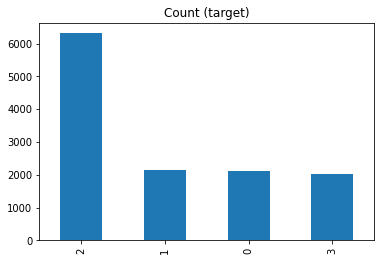

In [5]:
# print class distribution 
data_train_all["Label"].value_counts().plot(kind='bar', title='Count (target)')

# Tokenize

Tokenize Data

- encode in the right format for XLM-Roberta ( <s\> = sentence beginning, </s\> end of sentence/sentence seperator)

- Truncate/Padding so everything has the same length

In [6]:
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )

In [7]:
max_len=64

def tokenizer_xlm(data, max_len):
  labels_ = []
  input_ids_ = []
  attn_masks_ = []

  # for each datasample:
  for index, row in data.iterrows():

      word1 = row['Word1']
      word2 = row['Word2']

      # create requiered input, i.e. ids and attention masks
      encoded_dict = xlmr_tokenizer.encode_plus(word1, word2, 
                                                max_length=max_len, 
                                                padding='max_length',
                                                truncation=True, 
                                                return_tensors='pt')

      # add encoded sample to lists
      input_ids_.append(encoded_dict['input_ids'])
      attn_masks_.append(encoded_dict['attention_mask'])
      labels_.append(row['Label'])
      
  # Convert each Python list of Tensors into a 2D Tensor matrix.
  input_ids_ = torch.cat(input_ids_, dim=0)
  attn_masks_ = torch.cat(attn_masks_, dim=0)

  # labels to tensor
  labels_ = torch.tensor(labels_)

  print('Encoder finished. {:,} examples.'.format(len(labels_)))
  return input_ids_, attn_masks_, labels_

In [8]:
# tokenize data

#all
print("All")
input_ids_train_all, attn_masks_train_all, labels_train_all = tokenizer_xlm(data_train_all, max_len)
input_ids_valid_all, attn_masks_valid_all, labels_valid_all = tokenizer_xlm(data_valid_all, max_len)

#zh
print("zh")
input_ids_train_zh, attn_masks_train_zh, labels_train_zh = tokenizer_xlm(data_train_zh, max_len)
input_ids_valid_zh, attn_masks_valid_zh, labels_valid_zh = tokenizer_xlm(data_valid_zh, max_len)

#en
print("en")
input_ids_train_en, attn_masks_train_en, labels_train_en = tokenizer_xlm(data_train_en, max_len)
input_ids_valid_en, attn_masks_valid_en, labels_valid_en = tokenizer_xlm(data_valid_en, max_len)

#de
print("de")
input_ids_train_de, attn_masks_train_de, labels_train_de = tokenizer_xlm(data_train_de, max_len)
input_ids_valid_de, attn_masks_valid_de, labels_valid_de = tokenizer_xlm(data_valid_de, max_len)

All
Encoder finished. 12,606 examples.
Encoder finished. 4,201 examples.
zh
Encoder finished. 2,514 examples.
Encoder finished. 838 examples.
en
Encoder finished. 5,210 examples.
Encoder finished. 1,736 examples.
de
Encoder finished. 4,882 examples.
Encoder finished. 1,627 examples.


In [9]:
# Combine the training inputs into a TensorDataset.

#all
tensor_data_train_all = TensorDataset(input_ids_train_all, attn_masks_train_all, labels_train_all)
tensor_data_valid_all = TensorDataset(input_ids_valid_all, attn_masks_valid_all, labels_valid_all)
#zh
tensor_data_train_zh = TensorDataset(input_ids_train_zh, attn_masks_train_zh, labels_train_zh)
tensor_data_valid_zh = TensorDataset(input_ids_valid_zh, attn_masks_valid_zh, labels_valid_zh)
#en
tensor_data_train_en = TensorDataset(input_ids_train_en, attn_masks_train_en, labels_train_en)
tensor_data_valid_en = TensorDataset(input_ids_valid_en, attn_masks_valid_en, labels_valid_en)
#de
tensor_data_train_de = TensorDataset(input_ids_train_de, attn_masks_train_de, labels_train_de)
tensor_data_valid_de = TensorDataset(input_ids_valid_de, attn_masks_valid_de, labels_valid_de)

In [10]:
#prepare pytorch dataloaders

batch_size = 32

#all
train_dataloader_all = DataLoader(tensor_data_train_all, sampler = RandomSampler(tensor_data_train_all), batch_size = batch_size) #random sampling
validation_dataloader_all = DataLoader(tensor_data_valid_all, sampler = SequentialSampler(tensor_data_valid_all),batch_size = batch_size ) #sequential sampling
#zh
train_dataloader_zh = DataLoader(tensor_data_train_zh, sampler = RandomSampler(tensor_data_train_zh), batch_size = batch_size)
validation_dataloader_zh = DataLoader(tensor_data_valid_zh, sampler = SequentialSampler(tensor_data_valid_zh),batch_size = batch_size)
#en
train_dataloader_en = DataLoader(tensor_data_train_en, sampler = RandomSampler(tensor_data_train_en), batch_size = batch_size)
validation_dataloader_en = DataLoader(tensor_data_valid_en, sampler = SequentialSampler(tensor_data_valid_en),batch_size = batch_size)
#de
train_dataloader_de = DataLoader(tensor_data_train_de, sampler = RandomSampler(tensor_data_train_de), batch_size = batch_size)
validation_dataloader_de = DataLoader(tensor_data_valid_de, sampler = SequentialSampler(tensor_data_valid_de),batch_size = batch_size)

# Training the Classifier (Finetuning XLM-RoBERTa)

In [12]:
#load the pretrained model provided by HuggingFace with an added untrained classification head for 4 classes
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=4)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [13]:
#choose training set used for this single training example (original training data for final model)
train_dataloader = train_dataloader_all
print("Training Samples:",len(train_dataloader.dataset))

Training Samples: 12606


In [14]:
# connect to GPU 
device = torch.device('cuda')
# copy weights onto GPU
desc = xlmr_model.to(device)

print('Connected to GPU:', torch.cuda.get_device_name(0))

Connected to GPU: Tesla T4


Set parameters (learning rate & epochs)

In [15]:
optimizer = AdamW(xlmr_model.parameters(),
                  lr = 2e-5,   # do work well: 2e-5 with 5-7 epochs for trainall, 1e-5
                  eps = 1e-8   # 1e-8
                  # weight_decay = 0          
                  )

In [16]:
# number of training epochs
epochs = 7

# number of batches x epochs
total_steps = len(train_dataloader) * epochs
print("total steps:", total_steps)

#scheduler for lr
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,   #start low and increase learning rate during these steps
                                            num_training_steps = total_steps)

total steps: 2758


Formatting functions

In [17]:
# return time as hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  


Validation function

In [18]:
def validate(validation_dataloader, xlmr_model, verbose): 
  
  # put model in evaluation mode 
  xlmr_model.eval()

  # variable for loss, predictions and labels
  total_eval_loss = 0
  predictions, true_labels = [], []

  # Evaluate data for one epoch
  for batch in validation_dataloader:
          
      # Unpack training batch and copy the tensors to the gpu
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
          
      # no backprop needed
      with torch.no_grad():        

          # forward pass
          output = xlmr_model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
          loss=output.loss
          logits=output.logits
              
      # add up loss
      total_eval_loss += loss.item()

      # on cpu
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # save preds/true labels
      predictions.append(logits)
      true_labels.append(label_ids)

  # results of the whole validation set
  flat_predictions = np.concatenate(predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # logit to label
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

  # print classification report
  if verbose:
    print(classification_report(flat_true_labels, predicted_labels, target_names=labels))

  # Calculate the validation accuracy, macro f1, and weighted f1 without RANDOM
  val_accuracy = (predicted_labels == flat_true_labels).mean()
  macroF1 = f1_score(flat_true_labels, predicted_labels, average='macro')
  weightedF1_no_random=f1_score(flat_true_labels, predicted_labels, average='weighted', labels=[0,1,3])
  print("\t Weighted F1 (no random):", weightedF1_no_random)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # plot confusion matrix
  if verbose:
    print(confusion_matrix(flat_true_labels, predicted_labels, labels=[0,1,2,3]))

  return avg_val_loss, val_accuracy, macroF1, weightedF1_no_random
      

Training

In [19]:
def train_model(epochs, xlmr_model, train_dataloader, validation_dataloader_set, random_seed, verbose):

  seed_val = random_seed

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # mostly contains scores about how the training went for each epoch
  training_stats = []

  # total training time
  total_t0 = time.time()

  print('\033[1m'+"================ Model Training ================"+'\033[0m')

  # For each epoch...
  for epoch_i in range(0, epochs):

      print("")
      print('\033[1m'+'======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs)+'\033[0m')

      t0 = time.time()

      # summed training loss of the epoch
      total_train_loss = 0


      # model is being put into training mode as mechanisms like dropout work differently during train and test time
      xlmr_model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # unpack training batch at load it to gpu (device)  
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # clear gradients before calculating new ones
          xlmr_model.zero_grad()        

          # forward pass with current batch
          output = xlmr_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
          
          loss=output.loss
          logits=output.logits

          # add up the loss
          total_train_loss += loss.item()

          # calculate new gradients
          loss.backward()

          # gradient clipping (not bigger than)
          torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

          # Update the networks weights based on the gradient as well as the optimiziers parameters
          optimizer.step()

          # lr update
          scheduler.step()

      # avg loss over all batches
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # training time of this epoch
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
  
      # VALIDATION

      #all
      print("evaluate on all")
      avg_val_loss_all, val_accuracy_all, macroF1_all, weightedF1_no_random_all = validate(validation_dataloader_set[0], xlmr_model, verbose)   
      #zh
      print("evaluate on zh")
      avg_val_loss_zh, val_accuracy_zh, macroF1_zh, weightedF1_no_random_zh = validate(validation_dataloader_set[1], xlmr_model, verbose) 
      #en
      print("evaluate on en")
      avg_val_loss_en, val_accuracy_en, macroF1_en, weightedF1_no_random_en = validate(validation_dataloader_set[2], xlmr_model, verbose) 
      #de
      print("evaluate on de")
      avg_val_loss_de, val_accuracy_de, macroF1_de, weightedF1_no_random_de = validate(validation_dataloader_set[3], xlmr_model, verbose)  
       

      print('\033[1m'+ "  Validation Loss All: {0:.2f}".format(avg_val_loss_all) + '\033[0m')

      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss all': avg_val_loss_all,
              'Valid. Accur. all': val_accuracy_all,
              'Weigh_F1 all (no random)': weightedF1_no_random_all, 
              'Macro F1 all': macroF1_all,
              'Weigh_F1 en': weightedF1_no_random_en,
              'Weigh_F1 de': weightedF1_no_random_de,
              'Weigh_F1 zh': weightedF1_no_random_zh,
              'Training Time': training_time,
          }
      )

  print("\n\nTraining complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  
  return training_stats


In [ ]:
# start training
validation_dataloader_set=[validation_dataloader_all, validation_dataloader_zh, validation_dataloader_en, validation_dataloader_de]
training_stats=train_model(epochs=epochs, 
                           xlmr_model=xlmr_model, 
                           train_dataloader=train_dataloader, 
                           validation_dataloader_set=validation_dataloader_set,
                           random_seed=42,
                           verbose=True)  

================ Model Training ================

======== Epoch 1 / 7 ========

  Average training loss: 1.24
  Training epoch took: 0:02:49
evaluate on all
              precision    recall  f1-score   support

         ANT       0.27      0.16      0.20       719
         HYP       0.46      0.16      0.24       731
      RANDOM       0.64      0.87      0.74      2091
         SYN       0.34      0.36      0.35       660

    accuracy                           0.54      4201
   macro avg       0.43      0.39      0.38      4201
weighted avg       0.50      0.54      0.50      4201

	 Weighted F1 (no random): 0.2602448727180897
[[ 112   45  386  176]
 [  76  119  342  194]
 [ 129   56 1812   94]
 [  96   41  284  239]]
evaluate on zh
              precision    recall  f1-score   support

         ANT       0.40      0.15      0.22       136
         HYP       0.65      0.25      0.36       145
      RANDOM       0.91      0.79      0.85       428
         SYN       0.33      0.91   

# Evaluation Statistics

In [ ]:
# Table with training stats
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss all,Valid. Accur. all,Weigh_F1 all (no random),Macro F1 all,Weigh_F1 en,Weigh_F1 de,Weigh_F1 zh,Training Time
epoch,,,,,,,,,
1,1.24,1.11,0.54,0.26,0.38,0.23,0.21,0.35,0:02:49
2,1.03,0.97,0.61,0.46,0.54,0.43,0.36,0.75,0:02:52
3,0.87,0.88,0.65,0.50,0.57,0.44,0.39,0.80,0:02:52
4,0.76,0.88,0.66,0.51,0.58,0.45,0.40,0.83,0:02:52
5,0.67,0.93,0.67,0.52,0.59,0.47,0.42,0.82,0:02:52
6,0.61,0.93,0.67,0.52,0.59,0.48,0.42,0.82,0:02:52
7,0.56,0.98,0.67,0.54,0.60,0.49,0.44,0.84,0:02:52


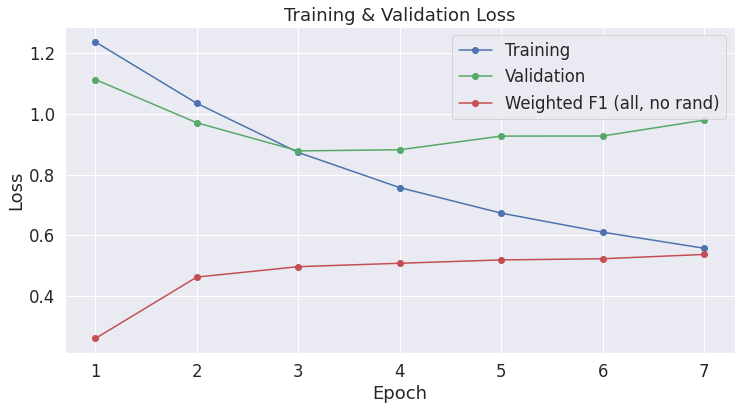

In [ ]:
# Plot Trainingloss, Validation loss and Weighted F1 score for each epoch

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss all'], 'g-o', label="Validation")
plt.plot(df_stats['Weigh_F1 all (no random)'], 'r-o', label="Weighted F1 (all, no rand)")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# save model
#PATH = "xlmr_model2409.pt"
#torch.save(xlmr_model, PATH)

In [ ]:
#load
PATH = "xlmr_model2409.pt"
xlmr_model=torch.load(PATH)

# CogALex Evaluation 

In [ ]:
# read in test data
test_data_zh = pd.read_csv('data/test/test_chinese_data.txt', sep="\t", header=None)
test_data_zh.columns = ["Word1", "Word2"]

test_data_de = pd.read_csv('data/test/test_german_data.txt', sep="\t", header=None)
test_data_de.columns = ["Word1", "Word2"]

test_data_en = pd.read_csv('data/test/test_english_data.txt', sep="\t", header=None)
test_data_en.columns = ["Word1", "Word2"]

test_data_it = pd.read_csv('data/test/test_italian_data.txt', sep="\t", header=None)
test_data_it.columns = ["Word1", "Word2"]

In [ ]:
# annotates a file that was already parsed to a dataframe (uses tokenizer from before)

def annotate_test_data(test_data, output_file_name):
  file = open(output_file_name,"w") 
  for index, row in test_data.iterrows():
      word1=row["Word1"]
      word2=row["Word2"]  
      encoded_dict = xlmr_tokenizer.encode_plus(word1, word2, 
                                                  max_length=max_len, 
                                                  padding='max_length',
                                                  truncation=True, 
                                                  return_tensors='pt') 
      input_id=encoded_dict['input_ids'].to(device)
      attn_mask=encoded_dict['attention_mask'].to(device)
      label=torch.tensor(0).to(device)                    #0=antonym, 1=hypony, 2=random, 3=synonym
      (loss, logits) = xlmr_model(input_id, 
                                    token_type_ids=None, 
                                    attention_mask=attn_mask,
                                    labels=label)
      logits = logits.detach().cpu().numpy()

      #write to file 
      file.write(word1+"\t"+word2+"\t"+labels[logits[0].argmax(axis=0)]+"\n") 
  file.close() 

In [ ]:
#annotate the unlabeled test sets
annotate_test_data(test_data_it, "xlmr_it_annotated.txt")
annotate_test_data(test_data_zh, "xlmr_zh_annotated.txt")
annotate_test_data(test_data_en, "xlmr_en_annotated.txt")
annotate_test_data(test_data_de, "xlmr_de_annotated.txt")

In [ ]:
#zh
annotate_test_data(data_valid_zh, "valid_chinese_xlmr.txt")
#first arg: gold standard file, second arg: our results
! python evaluation_grade.py validgold_chinese_data.txt valid_chinese_xlmr.txt

validgold_chinese_data.txt
valid_chinese_xlmr.txt
Loading the datasets ...
Evaluating ...
      SYN:  P = 0.862  R = 0.822  F1 = 0.841  sup = 129
      HYP:  P = 0.938  R = 0.841  F1 = 0.887  sup = 145
      ANT:  P = 0.877  R = 0.838  F1 = 0.857  sup = 136
Overall:  P = 0.894  R = 0.834  F1 = 0.863


In [ ]:
#en
annotate_test_data(data_valid_en, "valid_english_xlmr.txt")
! python evaluation_grade.py validgold_english_data.txt valid_english_xlmr.txt

validgold_english_data.txt
valid_english_xlmr.txt
Loading the datasets ...
Evaluating ...
      SYN:  P = 0.492  R = 0.463  F1 = 0.477  sup = 259
      HYP:  P = 0.597  R = 0.473  F1 = 0.528  sup = 292
      ANT:  P = 0.801  R = 0.497  F1 = 0.613  sup = 308
Overall:  P = 0.639  R = 0.478  F1 = 0.543


In [ ]:
#de
annotate_test_data(data_valid_de, "valid_german_xlmr.txt")
! python evaluation_grade.py validgold_german_data.txt valid_german_xlmr.txt

validgold_german_data.txt
valid_german_xlmr.txt
Loading the datasets ...
Evaluating ...
      SYN:  P = 0.507  R = 0.419  F1 = 0.459  sup = 272
      HYP:  P = 0.595  R = 0.459  F1 = 0.518  sup = 294
      ANT:  P = 0.673  R = 0.411  F1 = 0.510  sup = 275
Overall:  P = 0.592  R = 0.430  F1 = 0.496


# GridSearch

In [20]:
def create_model(lr, eps, train_dataloader, epochs):
  xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=4)
  device = torch.device('cuda')
  desc = xlmr_model.to(device)
  optimizer = AdamW(xlmr_model.parameters(),
                  lr = lr,   
                  eps = eps       
                )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,   
                                            num_training_steps = total_steps)
  return xlmr_model, optimizer, scheduler
  


In [21]:
#parameters checked in gridsearch

parameter_grid=list(ParameterGrid({
    "model_name":["xlm-roberta-base"],
    "batch_size":[32], 
    "lr":[2e-5, 1e-5, 2e-6], 
    "eps":[1e-8], 
    "max_len":[64], 
    "epochs":[3], 
    "warmup_steps":[0],
    "weight_decay":[0],
    "random_seed": [42]
    #"number_samples": [100,500,1000,5000,10000,12606]
    }))

print("Grid size:",len(parameter_grid))
print(parameter_grid)

Grid size: 3
[{'batch_size': 32, 'epochs': 3, 'eps': 1e-08, 'lr': 2e-05, 'max_len': 64, 'model_name': 'xlm-roberta-base', 'random_seed': 42, 'warmup_steps': 0, 'weight_decay': 0}, {'batch_size': 32, 'epochs': 3, 'eps': 1e-08, 'lr': 1e-05, 'max_len': 64, 'model_name': 'xlm-roberta-base', 'random_seed': 42, 'warmup_steps': 0, 'weight_decay': 0}, {'batch_size': 32, 'epochs': 3, 'eps': 1e-08, 'lr': 2e-06, 'max_len': 64, 'model_name': 'xlm-roberta-base', 'random_seed': 42, 'warmup_steps': 0, 'weight_decay': 0}]


In [22]:
def gridsearch(parameter_grid, data_train):

  validation_dataloader_set=[validation_dataloader_all, validation_dataloader_zh, validation_dataloader_en, validation_dataloader_de]

  print("Starting Gridsearch")

  results=[]

  for i, parameters in enumerate(parameter_grid):

    #number_samples=parameters["number_samples"]
    #data_train=data_train_all.sample(number_samples)

    model_name=parameters["model_name"]
    batch_size=parameters["batch_size"]
    lr=parameters["lr"]
    eps=parameters["eps"]
    max_len=parameters["max_len"]
    epochs=parameters["epochs"]
    warmup_steps=parameters["warmup_steps"]
    random_seed=parameters["random_seed"]

    print("\n"+"\033[1m"+"============== Iteration "+str(i+1)+"/"+str(len(parameter_grid))+" =============="+"\033[0m"+"\n")
    print(parameters)
    print("length training data:", len(data_train))
    #print(data_train)
    
    # prepare chosen trainings data
    xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
    input_ids_train, attn_masks_train, labels_train = tokenizer_xlm(data_train, max_len)
    tensor_data_train = TensorDataset(input_ids_train, attn_masks_train, labels_train)
    train_dataloader = DataLoader(
                tensor_data_train,  
                sampler = RandomSampler(tensor_data_train), 
                batch_size = batch_size 
            )

    
    # prepare model
    xlmr_model, optimizer, scheduler = create_model(lr, eps, train_dataloader, epochs) 

    # train and save stats
    training_stats=train_model( epochs=epochs, 
                                xlmr_model=xlmr_model, 
                                train_dataloader=train_dataloader, 
                                validation_dataloader_set=validation_dataloader_set,
                                random_seed=random_seed,
                                verbose = False) 
  
    df_stats = pd.DataFrame(data=training_stats)

    #parameters, valid loss, min valid lost, macro f1
    results.append((parameters,
                    training_stats[len(training_stats)-1]["Valid. Loss all"],
                    min(df_stats["Valid. Loss all"]),
                    training_stats[len(training_stats)-1]['Weigh_F1 all (no random)']))
  return results

In [ ]:
# run gridsearch
results = gridsearch(parameter_grid, data_train_all)

In [ ]:
# show results
for r in results: print(r)

In [ ]:
# sort results by best 
sorted(results, key=lambda tup: tup[1])